<a href="https://colab.research.google.com/github/irfanbykara/Machine-Learning-Notebooks/blob/main/Deepfake_Detection_EfficientNetAutoAttB4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Video Face Manipulation Detection Through Ensemble of CNNs
For this notebook I give credit to :
Image and Sound Processing Lab - Politecnico di Milano
- Nicolò Bonettini
- Edoardo Daniele Cannas
- Sara Mandelli
- Luca Bondi
- Paolo Bestagini

Purpose of this notebook to do deepfake detection using pretrained ensamble efficient net based model proposed in the paper: https://arxiv.org/pdf/2004.07676v1.pdf

In [ ]:
!git clone https://github.com/polimi-ispl/icpr2020dfdc
!pip install efficientnet-pytorch
!pip install -U git+https://github.com/albu/albumentations > /dev/null
%cd icpr2020dfdc/notebook

Cloning into 'icpr2020dfdc'...
remote: Enumerating objects: 645, done.
remote: Counting objects: 100% (108/108), done.
remote: Compressing objects: 100% (28/28), done.
remote: Total 645 (delta 96), reused 80 (delta 80), pack-reused 537
Receiving objects: 100% (645/645), 99.63 MiB | 33.47 MiB/s, done.
Resolving deltas: 100% (336/336), done.
Updating files: 100% (81/81), done.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Running command git clone --filter=blob:none --quiet https://github.com/albu/albumentations /tmp/pip-req-build-km5xnnve
/content/icpr2020dfdc/notebook/icpr2020dfdc/notebook/icpr2020dfdc/notebook


In [ ]:
%cd icpr2020dfdc

/content/icpr2020dfdc


In [ ]:
import torch
from torch.utils.model_zoo import load_url
from PIL import Image
import matplotlib.pyplot as plt

import sys
sys.path.append('..')
#%matplotlib inline
import argparse
import os
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML
import zipfile
import requests 
from pathlib import Path


from blazeface import FaceExtractor, BlazeFace
from architectures import fornet,weights
from isplutils import utils

In [ ]:
%cd notebook

/content/icpr2020dfdc/notebook


## Parameters

In [ ]:
"""
Choose an architecture between
- EfficientNetB4
- EfficientNetB4ST
- EfficientNetAutoAttB4
- EfficientNetAutoAttB4ST
- Xception
"""
net_model = 'EfficientNetAutoAttB4'

"""
Choose a training dataset between
- DFDC
- FFPP
"""
train_db = 'DFDC'

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
face_policy = 'scale'
face_size = 224

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')
PATH_OF_DATA= '/content/gdrive/MyDrive/AI/'


Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
# # Setup path to data folder
data_path = Path("/content/gdrive/MyDrive/AI/")


In [ ]:
import requests
import zipfile
from pathlib import Path

image_path_2 = data_path / "deepfake_2"

# If the image folder doesn't exist, download it and prepare it... 
if image_path_2.is_dir():
    print(f"{image_path_2} directory exists.")
else:
    print(f"Did not find {image_path_2} directory, creating one...")
    image_path_2.mkdir(parents=True, exist_ok=True)
    
with zipfile.ZipFile(data_path / "deepfake2.zip", "r") as zip_ref:
    print("Unzipping data...") 
    zip_ref.extractall(image_path_2)

In [ ]:
image_path_2 = data_path / "deepfake_2"


## Initialization

In [ ]:
model_url = weights.weight_url['{:s}_{:s}'.format(net_model,train_db)]
net = getattr(fornet,net_model)().eval().to(device)
net.load_state_dict(load_url(model_url,map_location=device,check_hash=True))

Loaded pretrained weights for efficientnet-b4


<All keys matched successfully>

In [ ]:
transf = utils.get_transformer(face_policy, face_size, net.get_normalizer(), train=False)

In [ ]:
facedet = BlazeFace().to(device)
facedet.load_weights("../blazeface/blazeface.pth")
facedet.load_anchors("../blazeface/anchors.npy")
face_extractor = FaceExtractor(facedet=facedet)

## Load images

## Extract faces

In [ ]:
all_images_paths = list(image_path_2.glob("*/*/*/*/*.jpg"))
all_images_paths

[PosixPath('/content/gdrive/MyDrive/AI/deepfake_2/Task_2_3/evaluation/fake/id0_id2_0001/id0_id2_0001_000.jpg'),
 PosixPath('/content/gdrive/MyDrive/AI/deepfake_2/Task_2_3/evaluation/fake/id0_id2_0001/id0_id2_0001_001.jpg'),
 PosixPath('/content/gdrive/MyDrive/AI/deepfake_2/Task_2_3/evaluation/fake/id0_id2_0001/id0_id2_0001_002.jpg'),
 PosixPath('/content/gdrive/MyDrive/AI/deepfake_2/Task_2_3/evaluation/fake/id0_id2_0001/id0_id2_0001_003.jpg'),
 PosixPath('/content/gdrive/MyDrive/AI/deepfake_2/Task_2_3/evaluation/fake/id0_id2_0001/id0_id2_0001_004.jpg'),
 PosixPath('/content/gdrive/MyDrive/AI/deepfake_2/Task_2_3/evaluation/fake/id0_id2_0001/id0_id2_0001_005.jpg'),
 PosixPath('/content/gdrive/MyDrive/AI/deepfake_2/Task_2_3/evaluation/fake/id0_id2_0001/id0_id2_0001_006.jpg'),
 PosixPath('/content/gdrive/MyDrive/AI/deepfake_2/Task_2_3/evaluation/fake/id0_id2_0001/id0_id2_0001_007.jpg'),
 PosixPath('/content/gdrive/MyDrive/AI/deepfake_2/Task_2_3/evaluation/fake/id0_id2_0001/id0_id2_0001_008

In [ ]:
all_faces = []
for path in all_images_paths:
  img  = Image.open(path)
  img = face_extractor.process_image(img=img)['faces'][0]
  all_faces.append(img)
del all_images_paths

In [ ]:
faces_t = torch.stack( [ transf(image=im)['image'] for im in all_faces ] )
with torch.no_grad():
  faces_pred = torch.sigmoid(net(faces_t.to(device))).cpu().numpy().flatten()


In [ ]:
batch_size = 32
n_faces = len(all_faces)
n_batches = (n_faces + batch_size - 1) // batch_size

faces_pred = []

for i in range(n_batches):
    start_idx = i * batch_size
    end_idx = min((i + 1) * batch_size, n_faces)
    batch_faces = all_faces[start_idx:end_idx]
    batch_t = torch.stack([transf(image=im)['image'] for im in batch_faces])
    with torch.no_grad():
        batch_pred = torch.sigmoid(net(batch_t.to(device))).cpu().numpy().flatten()
    faces_pred.append(batch_pred)

faces_pred = np.concatenate(faces_pred)


In [ ]:
faces_pred_copy = faces_pred.copy()

In [ ]:
faces_pred_copy.round()

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 0., 0., 0., 1., 0., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 0., 0., 0., 1., 0.,
       1., 1., 1., 1., 0., 0., 0., 1., 1., 1., 1., 0., 1., 0., 0., 0., 0.,
       0., 1., 0., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1.

In [ ]:
target = []
for path in all_images_paths:
  if 'real' in str(path):
    target.append(0)
  else:
    target.append(1)


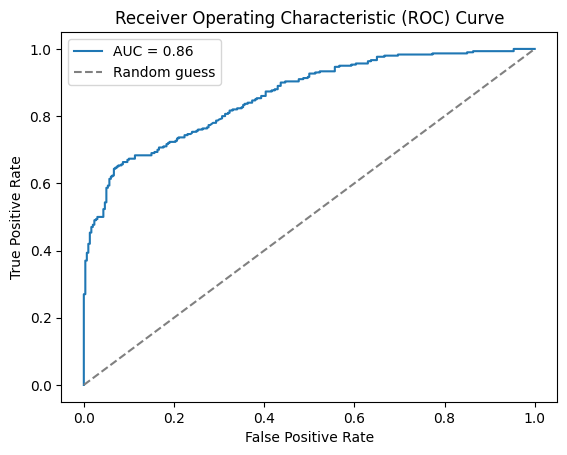

In [ ]:
from sklearn.metrics import roc_curve, auc

fpr, tpr, thresholds = roc_curve(target, faces_pred)

# Compute area under the curve (AUC)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.plot(fpr, tpr, label=f'AUC = {roc_auc:.2f}')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Random guess')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()
plt.show()


## Predict scores

In [ ]:
faces_pred_copy[faces_pred_copy > 0.5] = 0
faces_pred_copy[faces_pred_copy <= 0.5] = 1
faces_pred_copy

In [ ]:
from sklearn.metrics import accuracy_score
accuracy_score(target, faces_pred_copy.round())


0.7433333333333333

In [ ]:
class_names = ['Real','Fake']

In [ ]:
import random
rand_list = []
for i in range(16):
  rand_list.append(random.randint(0,600))

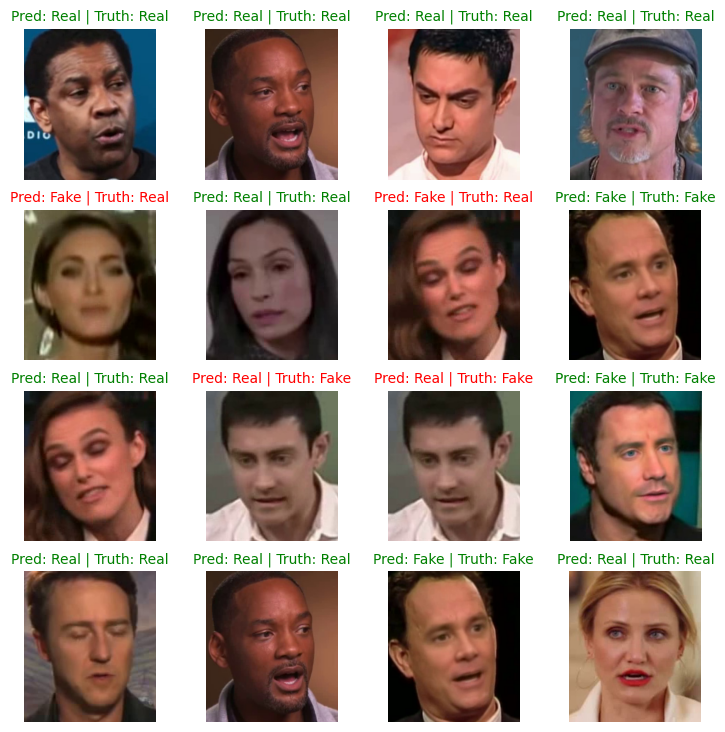

In [ ]:
import matplotlib.pyplot as plt
# Plot predictions
plt.figure(figsize=(9, 9))
nrows = 4
ncols = 4
for i in range(len(rand_list)):
  # Create a subplot
  plt.subplot(nrows, ncols, i+1)

  # Plot the target image
  plt.imshow(all_faces[rand_list[i]], cmap="gray")

  # # Find the prediction label (in text form, e.g. "Sandal")
  pred_label = class_names[int(faces_pred_copy[rand_list[i]].round())]

  # # Get the truth label (in text form, e.g. "T-shirt")
  truth_label = class_names[target[rand_list[i]]] 

  # # Create the title text of the plot
  title_text = f"Pred: {pred_label} | Truth: {truth_label}"
  
  # # Check for equality and change title colour accordingly
  if pred_label == truth_label:
      plt.title(title_text, fontsize=10, c="g") # green text if correct
  else:
      plt.title(title_text, fontsize=10, c="r") # red text if wrong
  plt.axis(False);
